<a href="https://colab.research.google.com/github/Kavyagudipelly/coursenlp/blob/main/amazon_food_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and dataset

In [ ]:
import re
import pickle
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
from math import sqrt
from datetime import datetime
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import plotly.io as plt_io
import plotly.graph_objects as go

import nltk 
nltk.download('stopwords') 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn import pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import  LabelEncoder, StandardScaler, MaxAbsScaler
from sklearn.utils import shuffle
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, log_loss, make_scorer, mean_squared_error, accuracy_score, f1_score, silhouette_score
from sklearn.naive_bayes import BernoulliNB

#cluster and visualize
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
import spacy

#wordcloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests

#Keras
import keras
from keras.models import Sequential
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping 
from keras.preprocessing.text import one_hot,Tokenizer, text_to_word_sequence

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon/Reviews.csv', header=0, encoding="ISO-8859-1")

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Recommendation System

## EDA

In [ ]:
# droppping duplicate only keeping one per case
food_eda =data.drop_duplicates(subset=['UserId','ProductId'], keep='first', inplace=False)
food_eda.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# converting unix time to year/month/day format, hour/min/sec is not available
food_eda['Time_converted']=food_eda['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m-%d'))
#strftime('%Y-%m-%d %H:%M:%S'))
food_eda['Time_converted_ym']=food_eda['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m'))

In [ ]:
print('Earliest review:')
food_eda['Time_converted'].min()

Earliest review:


'1999-10-08'

In [ ]:
print('Latest review:')
food_eda['Time_converted'].max()

Latest review:


'2012-10-26'

Text(0.5, 1.0, 'Review Score count 1999-2012')

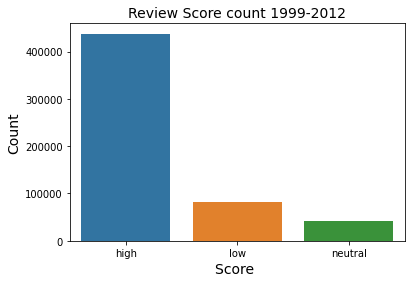

In [ ]:
def score_pos_neg(col):
    
    ''' This function get the score between 1 to 5 and return high for score >3 and return low for score <3, and neutral is =3
    as positive and negative respectively
    
    Input:
    
    col: number between 1 to 5 (review star)
    
    Return:
    
    return high, low, neutral
    '''
    
    if col > 3:
        return "high"
    elif col == 3:
        return "neutral"
    else:
        return "low"

food_eda['score_pos_neg']=food_eda['Score'].apply(score_pos_neg)

#plotting count of positive "1" and negative "0" reviews
sns.countplot(x='score_pos_neg', data=food_eda);
plt.xlabel('Score ',fontsize=14);
plt.ylabel('Count',fontsize=14);
plt.title('Review Score count 1999-2012',fontsize=14)

### Descriptive analysis

####A look at top reviewer population (individuals with more than 10 reviews)
* Top reviewer are group of users to have spent more time reviewing the products and expected to have more engagement with the community, impact of this engagement effectiveness is studied in terms of feedback they receive from the community fortheir review
* Individual with more than 10 review are in top review group, regardless of number of products
* Total review count per each user is analyzed against their average review helpfulness,as well as average review length

In [ ]:
# total review per user is grouped
user_number_review=food_eda.groupby(by=['UserId']).count().sort_values(by=['Text'],ascending=False)

user_number_review.head()

,Id,ProductId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Time_converted,Time_converted_ym,score_pos_neg
UserId,,,,,,,,,,,,
A3OXHLG6DIBRW8,420,420,420,420,420,420,420,420,420,420,420,420
AY12DBB0U420B,382,382,382,382,382,382,382,382,382,382,382,382
A281NPSIMI1C2R,321,321,321,321,321,321,321,321,321,321,321,321
A1YUL9PCJR3JTY,309,309,309,309,309,309,309,309,309,309,309,309
A1Z54EM24Y40LL,251,251,251,251,251,251,251,251,251,251,251,251


In [ ]:
# only individual with moe than 10 review incuded in top group
user_top_reviewer=user_number_review[user_number_review['Id']>10][['Id']]
user_top_reviewer.head(10)

,Id
UserId,
A3OXHLG6DIBRW8,420
AY12DBB0U420B,382
A281NPSIMI1C2R,321
A1YUL9PCJR3JTY,309
A1Z54EM24Y40LL,251
A2MUGFV2TDQ47K,201
AQQLWCMRNDFGI,167
AZV26LP92E6WU,167
A1UQBFCERIP7VJ,157


Text(0.5, 1.0, 'Review count for top reviewers')

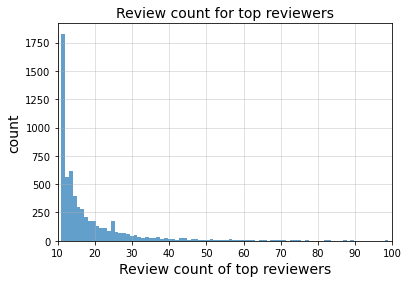

In [ ]:
# distribution of review count per user

user_top_reviewer['Id'].hist(bins=400,label='Number of reviews for Top (>10) reviewer',alpha=0.7);
plt.xlabel('Review count of top reviewers',fontsize=14);
plt.ylabel('count',fontsize=14);

plt.grid(linewidth=0.5,alpha=0.75)

plt.xlim(10,100)
plt.title('Review count for top reviewers',fontsize=14)

In [ ]:
user_top_reviewer['Id'].describe()

count    6105.000000
mean       19.760033
std        17.419443
min        11.000000
25%        12.000000
50%        15.000000
75%        21.000000
max       420.000000
Name: Id, dtype: float64


On average top reviewers write about 20 reviews, with very few <1% write over 40 review

In [ ]:
# getting average data per user
user_average_info=food_eda.groupby(by=['UserId']).mean()
user_average_info.head()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
UserId,,,,,
#oc-R103C0QSV1DF5E,136323.0,1.0,2.0,5.0,1.343088e+09
#oc-R109MU5OBBZ59U,516062.0,0.0,1.0,5.0,1.350086e+09
#oc-R10LFEMQEW6QGZ,516079.0,0.0,1.0,5.0,1.345939e+09
#oc-R10LT57ZGIB140,378693.0,0.0,0.0,3.0,1.310602e+09
#oc-R10UA029WVWIUI,136545.0,0.0,0.0,1.0,1.342483e+09


In [ ]:
# merging total review count and avg data per user
top_reviewer_avg_data=pd.merge(user_average_info,user_top_reviewer,how='inner',on='UserId')

In [ ]:
# calculate rtio of helpfulness, average number of people finding review helpful over total count commented on review
top_reviewer_avg_data['ratio_helpful']=top_reviewer_avg_data['HelpfulnessNumerator']/top_reviewer_avg_data['HelpfulnessDenominator']

top_reviewer_avg_data['Time_converted']=top_reviewer_avg_data['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m'))

In [ ]:
#making sure ratio of helpfulness between 0-1
top_reviewer_avg_data=top_reviewer_avg_data[(top_reviewer_avg_data['ratio_helpful']>0.0) & (top_reviewer_avg_data['ratio_helpful']<1.0)]

In [ ]:
top_reviewer_avg_data.head()

,Id_x,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Id_y,ratio_helpful,Time_converted
UserId,,,,,,,,
A100WO06OQR8BQ,295215.290909,0.836364,2.418182,3.109091,1.315171e+09,55,0.345865,2011-09
A101P2KHWCU0G6,306505.230769,0.346154,1.653846,2.038462,1.338788e+09,26,0.209302,2012-06
A102UXGLDF76G1,262626.636364,0.363636,0.545455,4.818182,1.243296e+09,11,0.666667,2009-05
A1051DBTLWP5A2,243877.961538,1.000000,1.038462,4.615385,1.323053e+09,26,0.962963,2011-12
A105S56ODHGJEK,296723.888889,0.111111,0.555556,3.222222,1.286256e+09,18,0.200000,2010-10


#### Review helpfulness distribution for top reviewers

Majority of people find top reviewer helpful


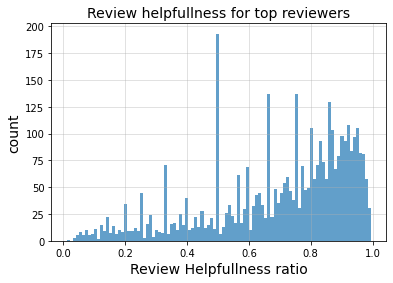

In [ ]:
# review helpfulness distribution
top_reviewer_avg_data['ratio_helpful'].hist(bins=100,label='review helpfullness top reviewers',alpha=0.7);

plt.xlabel('Review Helpfullness ratio',fontsize=14);
plt.ylabel('count',fontsize=14);

#plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)

plt.title('Review helpfullness for top reviewers',fontsize=14);

print('Majority of people find top reviewer helpful')

Majority of people find top reviewer helpful

#### Review helpfulness vs. review count for top reviewers

Top reviewers that write more frequent over 60 review (even though not many of them in dataset), receive very good feedback from community.

If the review write between 1-30 words no trend observed though.


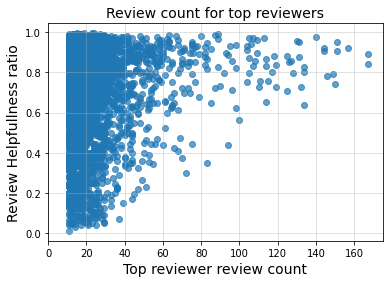

In [ ]:
#review helpfulness vs. review count
plt.scatter(top_reviewer_avg_data['Id_y'],top_reviewer_avg_data['ratio_helpful'],alpha=0.7);
plt.xlim(0,175);
plt.xlabel('Top reviewer review count',fontsize=14);
plt.ylabel('Review Helpfullness ratio',fontsize=14);

#plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)

plt.title('Review count for top reviewers',fontsize=14)

print('Top reviewers that write more frequent over 60 review (even though not many of them in dataset), receive very good feedback from community.') 
print('\nIf the review write between 1-30 words no trend observed though.')

Top reviewers that write more frequent over 60 review (even though not many of them in dataset), receive very good feedback from community. If the review write between 1-30 words no trend observed though.

#### Review  score/ length/helpfulness trendi in time
* Here the impact of time on review score, length, and helpfulness is studied
* Data are grouped by score, as well as total count per month of each year from 1999 to 2012

In [ ]:
# Divide the data by score and group for each month
grp_s1=food_eda[food_eda['Score']==1]
grp_s2=food_eda[food_eda['Score']==2]
grp_s3=food_eda[food_eda['Score']==3]
grp_s4=food_eda[food_eda['Score']==4]
grp_s5=food_eda[food_eda['Score']==5]

grp_date_1=grp_s1.groupby(by=['Time_converted_ym']).count();
grp_date_2=grp_s2.groupby(by=['Time_converted_ym']).count();
grp_date_3=grp_s3.groupby(by=['Time_converted_ym']).count();
grp_date_4=grp_s4.groupby(by=['Time_converted_ym']).count();
grp_date_5=grp_s5.groupby(by=['Time_converted_ym']).count();

grp_date_1.reset_index(inplace=True); #to make it to column
grp_date_2.reset_index(inplace=True);
grp_date_3.reset_index(inplace=True);
grp_date_4.reset_index(inplace=True);
grp_date_5.reset_index(inplace=True);

Text(0.5, 1.0, 'Number of review trend from 2000 to 2012')

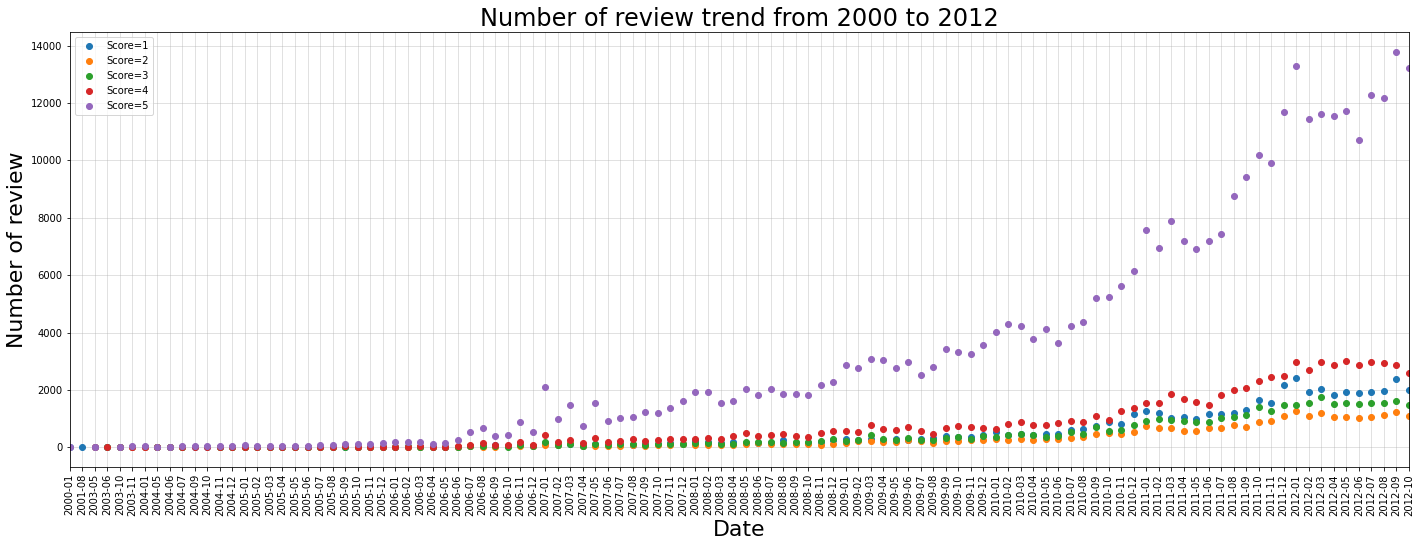

In [ ]:
# review count by score for each month from 2000 to 2012
plt.figure(figsize=(24,8))

plt.plot_date(x=grp_date_1['Time_converted_ym'],y=grp_date_1['Score'],label='Score=1');
plt.plot_date(x=grp_date_2['Time_converted_ym'],y=grp_date_2['Score'],label='Score=2');
plt.plot_date(x=grp_date_3['Time_converted_ym'],y=grp_date_3['Score'],label='Score=3');
plt.plot_date(x=grp_date_4['Time_converted_ym'],y=grp_date_4['Score'],label='Score=4');
plt.plot_date(x=grp_date_5['Time_converted_ym'],y=grp_date_5['Score'],label='Score=5');
plt.xticks(rotation=90);
plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlim('2000-01','2012-10');
plt.xlabel('Date',fontsize=22)
plt.ylabel('Number of review',fontsize=22)
plt.title('Number of review trend from 2000 to 2012',fontsize=24)

* From the 2000 to 2006 there is limited review available on Amazon, however trend start to change suddenly after 2006, the total number of 5 star review show biggest surge among other scores, this seems a bit unusual and one might ask people generally are optimistic or most possibly there are unverified accounts that are boosting the seller inappropriately with fake reviews
* Another interesting observation even though minimal, during January 2007,2008,2011 and 2012 slight increase in 5 start reviews are observed. Question is this slight increase due to cheerful holiday spirit?!
* The 1 to 4 star review count gradual increase make more sense due to more customer become aware of Amazon services.

In [ ]:
# average of helpfulness per month is calculated
grp_avg_date= food_eda.groupby(by=['Time_converted_ym']).mean()
grp_avg_date.reset_index(inplace=True);
grp_avg_date['Helpfulness_ratio']=grp_avg_date['HelpfulnessNumerator']/grp_avg_date['HelpfulnessDenominator']
grp_avg_date.head()

,Time_converted_ym,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Helpfulness_ratio
0,1999-10,150512.500000,1.000,1.000,5.0,940075200.0,1.000000
1,1999-12,377094.500000,0.750,1.500,5.0,944352000.0,0.500000
2,2000-01,330241.500000,7.875,9.375,3.5,947797200.0,0.840000
3,2000-02,352267.666667,2.000,3.000,4.0,951523200.0,0.666667
4,2000-06,211823.600000,3.400,4.800,5.0,960785280.0,0.708333


No special trend is observed, only seems that later in 2012 slight drop in helpfulness observed
 
that can be associated with the reciew itself being new and read fewer time


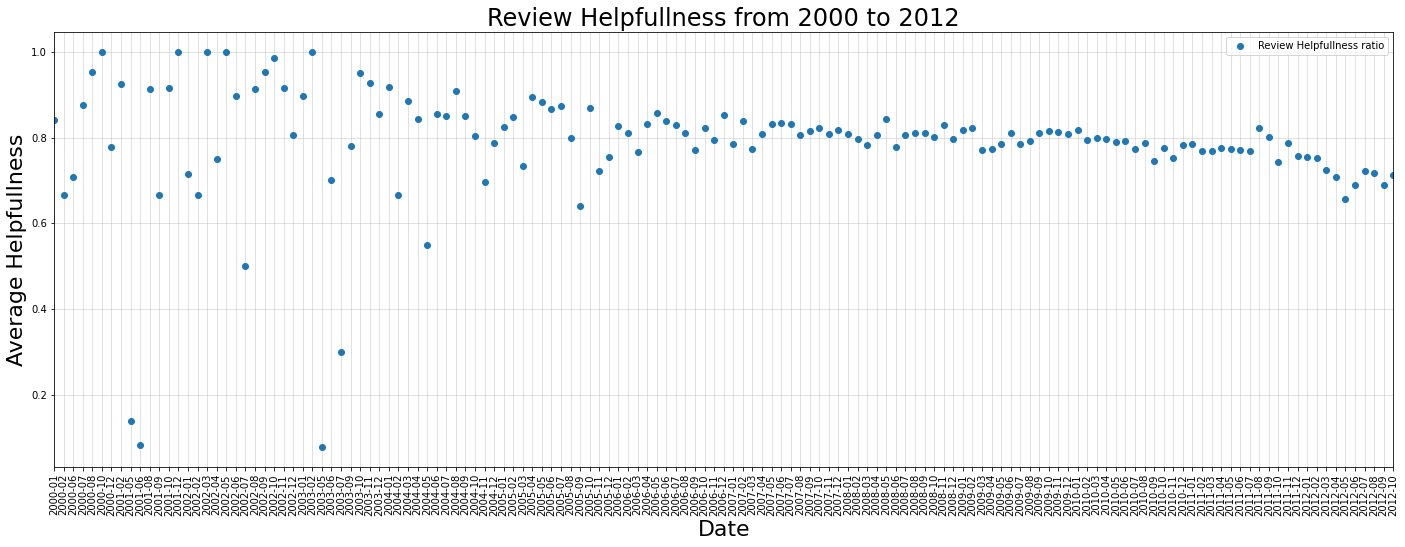

In [ ]:
# review helpfulness vs time
plt.figure(figsize=(24,8))
plt.plot_date(x=grp_avg_date['Time_converted_ym'],y=grp_avg_date['Helpfulness_ratio'],label='Review Helpfullness ratio');
plt.xticks(rotation=90);
plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlim('2000-01','2012-10');
plt.xlabel('Date',fontsize=22)
plt.ylabel('Average Helpfullness',fontsize=22)
plt.title('Review Helpfullness from 2000 to 2012',fontsize=24);

print('No special trend is observed, only seems that later in 2012 slight drop in helpfulness observed')
print(' \nthat can be associated with the reciew itself being new and read fewer time')

No special trend is observed, only seems that later in 2012 slight drop in helpfulness observed, that can be associated with the reciew itself being new and read fewer time

In [ ]:
food = food_eda.drop(['Id', 'ProfileName','Time','HelpfulnessNumerator','HelpfulnessDenominator','Text','Summary', 'Time_converted', 'Time_converted_ym'], axis = 1) 

In [ ]:
food.head()

,ProductId,UserId,Score,score_pos_neg
0,B001E4KFG0,A3SGXH7AUHU8GW,5,high
1,B00813GRG4,A1D87F6ZCVE5NK,1,low
2,B000LQOCH0,ABXLMWJIXXAIN,4,high
3,B000UA0QIQ,A395BORC6FGVXV,2,low
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,high


In [ ]:
# Check the number of rows and columns
rows, columns = food.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  560804
No of columns:  4


In [ ]:
#Check Data types
food.dtypes

ProductId        object
UserId           object
Score             int64
score_pos_neg    object
dtype: object

In [ ]:
# Check for missing values present
print('Number of missing values across columns-\n', food.isnull().sum())

Number of missing values across columns-
 ProductId        0
UserId           0
Score            0
score_pos_neg    0
dtype: int64


In [ ]:
# Summary statistics of 'rating' variable
food[['Score']].describe()

,Score
count,560804.000000
mean,4.183076
std,1.310530
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


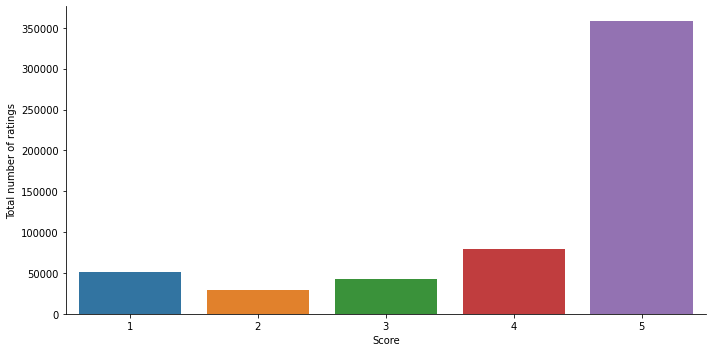

In [ ]:
g= sns.factorplot("Score", data=food, aspect=2.0,kind='count')
g.set_ylabels("Total number of ratings")

This high count of "5" star reviews will be revisited again with trend with time is addressed in later section

In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', food['UserId'].nunique())
print('Number of unique ITEMS in Raw data = ', food['ProductId'].nunique())

Number of unique USERS in Raw data =  256059
Number of unique ITEMS in Raw data =  74258


In [ ]:
# Top 10 users based on rating
most_rated = food.groupby('UserId').size().sort_values(ascending=False)[:10]
most_rated

UserId
A3OXHLG6DIBRW8    420
AY12DBB0U420B     382
A281NPSIMI1C2R    321
A1YUL9PCJR3JTY    309
A1Z54EM24Y40LL    251
A2MUGFV2TDQ47K    201
AQQLWCMRNDFGI     167
AZV26LP92E6WU     167
A1UQBFCERIP7VJ    157
A1WX42M589VAMQ    151
dtype: int64

In [ ]:
# Top 10 product based on rating
most_rated = food.groupby('ProductId').size().sort_values(ascending=False)[:10]
most_rated

ProductId
B007JFMH8M    913
B003B3OOPA    623
B002QWP8H0    609
B002QWP89S    609
B002QWHJOU    609
B0026RQTGE    609
B001EO5Q64    567
B000KV7ZGQ    555
B000KV61FC    555
B007M832YY    551
dtype: int64

##Recommendation system

### Building Popularity Recommender model

> Indented block



In [ ]:
#Count of user_id for each unique product as recommendation score 
food_recommend = data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
food_recommend.rename(columns = {'UserId': 'score'},inplace=True)
food_recommend.head()

,ProductId,score
0,0006641040,37
1,141278509X,1
2,2734888454,2
3,2841233731,1
4,7310172001,173


In [ ]:
#Sort the products on recommendation score 
recommend_sort = food_recommend.sort_values(['score', 'ProductId'], ascending = [0,1]) 

In [ ]:
#Generate a recommendation rank based upon score 
recommend_sort['Rank'] = recommend_sort['score'].rank(ascending=0, method='first') 
#top 5 recommendation
#Get the top 5 recommendations 
popularity_recommendations = recommend_sort.head(5) 
popularity_recommendations 

,ProductId,score,Rank
71170,B007JFMH8M,913,1.0
37898,B0026RQTGE,632,2.0
42257,B002QWHJOU,632,3.0
42263,B002QWP89S,632,4.0
42264,B002QWP8H0,632,5.0


In [ ]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['UserId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [ ]:
find_recom = [15,500,1000]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 15

       UserId   ProductId  score  Rank
71170      15  B007JFMH8M    913   1.0
37898      15  B0026RQTGE    632   2.0
42257      15  B002QWHJOU    632   3.0
42263      15  B002QWP89S    632   4.0
42264      15  B002QWP8H0    632   5.0


Here is the recommendation for the userId: 500

       UserId   ProductId  score  Rank
71170     500  B007JFMH8M    913   1.0
37898     500  B0026RQTGE    632   2.0
42257     500  B002QWHJOU    632   3.0
42263     500  B002QWP89S    632   4.0
42264     500  B002QWP8H0    632   5.0


Here is the recommendation for the userId: 1000

       UserId   ProductId  score  Rank
71170    1000  B007JFMH8M    913   1.0
37898    1000  B0026RQTGE    632   2.0
42257    1000  B002QWHJOU    632   3.0
42263    1000  B002QWP89S    632   4.0
42264    1000  B002QWP8H0    632   5.0






*  Since this is a popularity-based recommender model, recommendations remain the same for all users
*   We predict the products based on the popularity. It is not personalized to particular user



### Buidling Collabrating Filtering
* Model-based Collaborative Filtering: Singular Value Decomposition

####Data preparation

In [ ]:
#Take subset of dataset to make it less sparse/more dense. 
#Selecting users who has given 50 or more numbers of rating to selecting out top users
counts = food['UserId'].value_counts()
food_final = food[food['UserId'].isin(counts[counts >= 50].index)]

In [ ]:
print('Number of users who have rated 50 or more items:', len(food_final))
print('Number of unique USERS in final data:', food_final['UserId'].nunique())
print('Number of unique ITEMS in final data:', food_final['ProductId'].nunique())

Number of users who have rated 50 or more items: 19636
Number of unique USERS in final data: 235
Number of unique ITEMS in final data: 10990


In [ ]:
final_ratings_matrix = pd.pivot_table(food_final,index=['UserId'], columns = 'ProductId', values = "Score")
final_ratings_matrix.fillna(0,inplace=True)

In [ ]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings:', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings: ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (235, 10990)
given_num_of_ratings: 19636
possible_num_of_ratings:  2582650
density: 0.76%


In [ ]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

UserId,A100WO06OQR8BQ,A1080SE9X3ECK0,A11ED8O95W2103,A11OTLEDSW8ZXD,A132ETQPMHQ585,A13GZCHAMKWYBT,A13MKSASQ6YWL7,A13WOT3RSXKRD5,A16AXQ11SZA8SQ,A16KK3YHCWE29C,...,ATJN4KEHJBOC8,AVFA1JB08RG8G,AWKZAUC0D8DYL,AXO4PQU0XG3TG,AY12DBB0U420B,AY1EF0GOH80EK,AYB4ELCS5AM8P,AYGJ96W5KQMUJ,AYOMAHLWRQHUG,AZV26LP92E6WU
ProductId,,,,,,,,,,,,,,,,,,,,,
7310172001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7310172101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7800648702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004CI84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
B00004CXX9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_food = pd.pivot_table(food_final, index=['UserId'], columns = 'ProductId', values = "Score")
pivot_food.fillna(0,inplace=True)
print(pivot_food.shape)
pivot_food.head()

(235, 10990)


ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11OTLEDSW8ZXD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A132ETQPMHQ585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pivot_food['user_index'] = np.arange(0, pivot_food.shape[0], 1)
pivot_food.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4,user_index
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A11OTLEDSW8ZXD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A132ETQPMHQ585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
pivot_food.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_food.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **Apply Sparse Matrix with SVDS**

* Sparse matrix is a matrix which contains very few non-zero elements. When a sparse matrix is represented with a 2-dimensional array, we waste a lot of space to represent that matrix. 
* ```scipy.sparse.linalg.svds``` compute the largest or smallest k singular values/vectors for a sparse matrix. The order of the singular values is not guaranteed.
* SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and Latent Semantic Indexing (LSI), used in document retrieval and word similarity in Text mining
* In numerical analysis and scientific computing, a sparse matrix or sparse array is a matrix in which most of the elements are zero



In [ ]:
# Singular Value Decomposition
# 1000 Number of singular values and vectors to compute. 
U, sigma, Vt = svds(pivot_food, k = 100)
# Construct diagonal array in SVD
sigma = np.diag(sigma)


In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_food.columns)
preds_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
0,-0.037821,-0.037821,0.078598,0.049933,0.049933,0.065509,0.215730,0.049933,0.035880,-0.028353,...,0.192585,0.192585,-0.000774,0.192585,0.002340,0.185566,0.188089,-0.033768,-0.038083,0.050990
1,0.030308,0.030308,-0.066875,0.044197,0.044197,0.001155,0.015758,0.044197,-0.016811,0.008851,...,0.045640,0.045640,0.013920,0.045640,-0.011638,-0.010058,0.009090,-0.166798,-0.130751,-0.044743
2,0.018692,0.018692,0.017012,-0.059572,-0.059572,-0.001993,-0.014866,-0.059572,0.023238,-0.025875,...,0.002013,0.002013,-0.015085,0.002013,-0.013829,0.034179,0.048571,0.065817,-0.108934,-0.056355
3,0.018504,0.018504,0.016781,-0.049134,-0.049134,-0.010441,-0.035520,-0.049134,-0.039678,0.060872,...,0.071152,0.071152,0.000497,0.071152,-0.040525,0.016348,0.012943,-0.098175,-0.154382,0.332337
4,-0.001227,-0.001227,0.024059,0.152842,0.152842,-0.002572,0.007055,0.152842,0.009990,-0.072837,...,0.004711,0.004711,-0.005223,0.004711,0.007755,-0.029389,-0.047091,-0.025877,0.018861,0.102261


In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_food, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_food.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [ ]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 100
num_recommendations = 10
recommend_items(userID, pivot_food, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 100):

                   user_ratings  user_predictions
Recommended Items                                
B0041CIP3M                  0.0          1.721116
B004JGQ15E                  0.0          1.715258
B004BKLHOS                  0.0          1.373196
B001LG945O                  0.0          1.097526
B005HG9ESG                  0.0          1.041657
B005HG9ET0                  0.0          1.041657
B005HG9ERW                  0.0          1.041657
B002D4DY8G                  0.0          0.939378
B006BXUZVO                  0.0          0.897325
B008RWUHA6                  0.0          0.841672


####Evaluation
* Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.

In [ ]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

ProductId
7310172001    0.021277
7310172101    0.021277
7800648702    0.021277
B00004CI84    0.051064
B00004CXX9    0.051064
dtype: float64

In [ ]:
# Average PREDICTED rating for each item
preds_df.mean().head()

ProductId
7310172001    0.005563
7310172101    0.005563
7800648702    0.014872
B00004CI84    0.043011
B00004CXX9    0.043011
dtype: float64

In [ ]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(10990, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ProductId,,,
7310172001,0.021277,0.005563,0
7310172101,0.021277,0.005563,1
7800648702,0.021277,0.014872,2
B00004CI84,0.051064,0.043011,3
B00004CXX9,0.051064,0.043011,4


In [ ]:
#The lower the value, the better the performance of the model.
rmse = sqrt(mean_squared_error(final_ratings_matrix.mean(),preds_df.mean()))
print('\nRMSE SVD Model = {} \n'.format(rmse))


RMSE SVD Model = 0.006957463475726857 



* Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.
* Based on the real value and the predict value, it is clear to see that the predictive recomendation system is great

In [ ]:
#retest
#Enter 'userID' and 'num_recommendations' for the user #
userID = 70
num_recommendations = 6
recommend_items(userID, pivot_food, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 70):

                   user_ratings  user_predictions
Recommended Items                                
B000F4F952                  0.0          0.874849
B000KOUKK6                  0.0          0.874002
B000GG1O6M                  0.0          0.864986
B0010VUG0C                  0.0          0.864919
B0014ET0OI                  0.0          0.859707
B002FC2DYW                  0.0          0.858675


* Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

* The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.You can see the differance above for the user id 70 and 100, The Popularity based model has recommended the same set of 5 or 6 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history

#NLP

##Clean data

In [ ]:
#make a copy of columns I need from raw data
text = food_eda.drop(['Id','ProductId','UserId', 'ProfileName', 'Summary', 'Time','Time_converted','Time_converted_ym'],axis=1)
text.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text,score_pos_neg
0,1,1,5,I have bought several of the Vitality canned d...,high
1,0,0,1,Product arrived labeled as Jumbo Salted Peanut...,low
2,1,1,4,This is a confection that has been around a fe...,high
3,3,3,2,If you are looking for the secret ingredient i...,low
4,0,0,5,Great taffy at a great price. There was a wid...,high


In [ ]:
text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560804 entries, 0 to 568453
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   HelpfulnessNumerator    560804 non-null  int64 
 1   HelpfulnessDenominator  560804 non-null  int64 
 2   Score                   560804 non-null  int64 
 3   Text                    560804 non-null  object
 4   score_pos_neg           560804 non-null  object
dtypes: int64(3), object(2)
memory usage: 41.8+ MB


In [ ]:
#for convinience we will create two classes i.e 1 for score >3 and 0 for score <3
text['Score']=np.where(text['Score']>3,1,0)

In [ ]:
#Sentiment adjustment
lab_to_sentiment = {0:'Negative', 1:'Positive'}
def label_decoder(label):
  return lab_to_sentiment[label]
text.Score = text.Score.apply(lambda x: label_decoder(x))

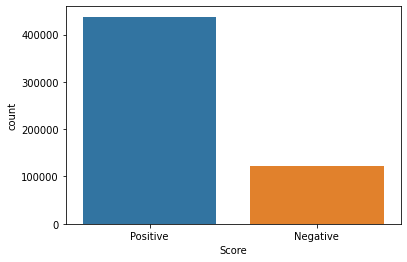

In [ ]:
sns.countplot(text['Score'])

In [ ]:
#Clean text
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@ \S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
#text preparing
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
%%time
text.Text = text.Text.apply(lambda x: preprocess(x))

CPU times: user 1min 34s, sys: 451 ms, total: 1min 35s
Wall time: 1min 35s


In [ ]:
# lenght of review calculated stored in new column
text['Text_lenght']=text['Text'].apply(lambda col: len(col.split(' ')))

In [ ]:
text.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text,score_pos_neg,Text_lenght
0,1,1,Positive,bought several vitality canned dog food produc...,high,23
1,0,0,Negative,product arrived labeled jumbo salted peanuts p...,low,18
2,1,1,Positive,confection around centuries light pillowy citr...,high,40
3,3,3,Negative,looking secret ingredient robitussin believe f...,low,18
4,0,0,Positive,great taffy great price wide assortment yummy ...,high,13


## EDA

### Calculating review lenghts
* Length of review is calculated (after cleaning) to understand impact of more in depth content on its helpfulness
* Reviews on average have about 80 words, very small <1% go beyond 400 words

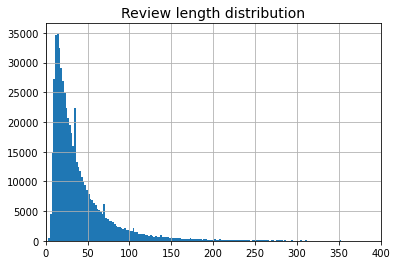

In [ ]:
text['Text_lenght'].hist(bins=1000);
plt.xlim(0,400)
plt.title('Review length distribution',fontsize=14);

In [ ]:
text['Text_lenght'].describe()

count    560804.000000
mean         41.207796
std          42.651941
min           1.000000
25%          17.000000
50%          28.000000
75%          50.000000
max        2061.000000
Name: Text_lenght, dtype: float64

* Length of review is calculated (after cleaning) to understand impact of more in depth content on its helpfulness
* Reviews on average have about 80 words, very small <1% go beyond 400 words

### Creating word collector for postive/ negative/ all reviews

CPU times: user 1min 25s, sys: 3.82 s, total: 1min 29s
Wall time: 1min 33s


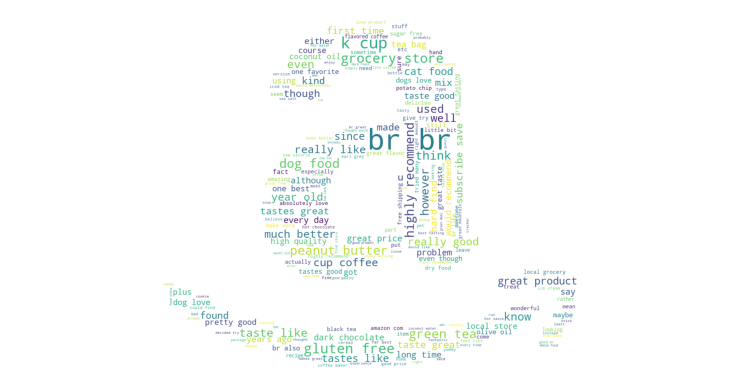

In [ ]:
%%time
po = str(text[text.Score == 'Positive'].Text.tolist())
mask = np.array(Image.open(requests.get('https://www.logolynx.com/images/logolynx/65/650538f0fb19686fd2c5fffe26f87fe9.png', stream=True).raw))


# Write a function takes in text and mask and generates a wordcloud. 
def generate_wordcloud(mask):
  word_cloud = WordCloud( background_color='white', stopwords=stop_words, mask=mask)
  word_cloud.generate(po)
  plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
  plt.imshow(word_cloud)
  plt.axis('off')
  plt.tight_layout(pad=0)

#Run the following to generate wordcloud
generate_wordcloud(mask)

CPU times: user 32.2 s, sys: 1.36 s, total: 33.5 s
Wall time: 35.7 s


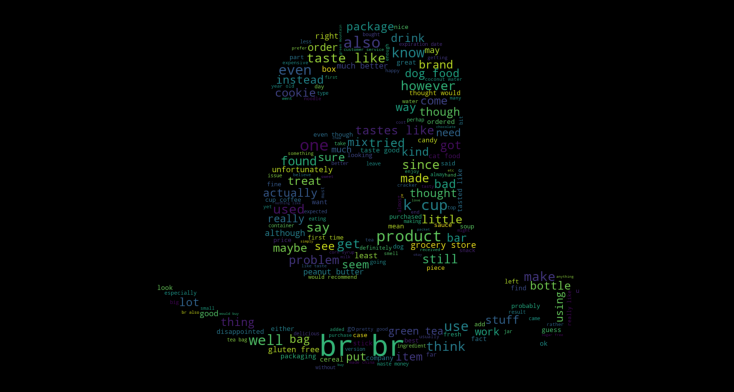

In [ ]:
%%time
ne = str(text[text.Score == 'Negative'].Text.tolist())
mask = np.array(Image.open(requests.get('https://www.logolynx.com/images/logolynx/65/650538f0fb19686fd2c5fffe26f87fe9.png', stream=True).raw))


# Write a function takes in text and mask and generates a wordcloud. 
def generate_wordcloud(mask):
  word_cloud = WordCloud( background_color='black', stopwords=stop_words, mask=mask)
  word_cloud.generate(ne)
  plt.figure(figsize=(10,8),facecolor = 'black', edgecolor='blue')
  plt.imshow(word_cloud)
  plt.axis('off')
  plt.tight_layout(pad=0)

#Run the following to generate wordcloud
generate_wordcloud(mask)

##Helpfull function

In [ ]:
text=text.drop(['Text_lenght'], axis=1)

In [ ]:
y=text['Score']
x=text['Text']

In [ ]:
#tranfer sentiment to interger
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y)

In [ ]:
#Lets's try to extract components via TruncatedSVD
#100-200 component are good enough for running model
svd = TruncatedSVD(n_components=140) #I chose 140

## Machine Learning - Classification

###BoW

* BoW is quite simple: the goal is to create a feature matrix such that the rows are observations, and each column is a unique word in vocabulary. I fill in this matrix by counting how many times each word appears in each observation.
* I will use single word models

#### Featuring engineering

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english') 
cv = count_vectorizer.fit_transform(x)
print('No. of feature_words: ', len(count_vectorizer.get_feature_names()))

No. of feature_words:  111344


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cv, y,
                                                    test_size = 0.1, random_state = 0)

In [ ]:
%%time
#fit svd into X_train
svd.fit(X_train)

## Transform x
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)

CPU times: user 1min 14s, sys: 6.35 s, total: 1min 21s
Wall time: 1min 2s


In [ ]:
print(X_train.shape)
print(X_train_svd.shape)
print(y_train.shape)

(504723, 111344)
(504723, 140)
(504723,)


In [ ]:
def model_Evaluate(model):    
  # Predict values for Test dataset
  y_pred = model.predict(X_test_svd)

  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)

  categories  = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
              xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':16}, pad = 20)

#### Modeling

In [ ]:
%%time
#testing how fit of the dataset
BNBmodel_bow = BernoulliNB(alpha = 2)
BNBmodel_bow.fit(X_train_svd, y_train)
print("----------------------Naive Bayes Scores----------------------")
print('Training set score:', BNBmodel_bow.score(X_train_svd, y_train))
print('Tesing set score:', BNBmodel_bow.score(X_test_svd, y_test))

----------------------Naive Bayes Scores----------------------
Training set score: 0.7971184194102507
Tesing set score: 0.7936199425830495
CPU times: user 3.06 s, sys: 283 ms, total: 3.34 s
Wall time: 2.88 s


In [ ]:
%%time
#making prediction
predictions_bnb_bow = BNBmodel_bow.predict_proba(X_train_svd)

#log loss
logloss_bow_bnb = log_loss(y_train, predictions_bnb_bow)

print ("logloss:  {:.3f}".format(logloss_bow_bnb))

#accuracy score
BNBmodel_bow_score = BNBmodel_bow.score(X_test_svd, y_test)

logloss:  0.447
CPU times: user 1.81 s, sys: 210 ms, total: 2.02 s
Wall time: 1.69 s


              precision    recall  f1-score   support

           0       0.58      0.27      0.37     12486
           1       0.82      0.94      0.88     43595

    accuracy                           0.79     56081
   macro avg       0.70      0.61      0.62     56081
weighted avg       0.77      0.79      0.76     56081

CPU times: user 354 ms, sys: 194 ms, total: 548 ms
Wall time: 333 ms


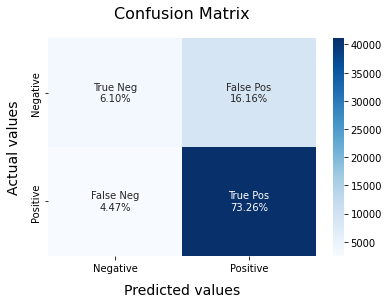

In [ ]:
#model evaluation
%%time
model_Evaluate(BNBmodel_bow)

In [ ]:
%%time
#testing how fit of the dataset
lr_bow = LogisticRegression()
lr_bow.fit(X_train_svd, y_train)

#testing overfiting
print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr_bow.score(X_train_svd, y_train))
print('Tesing set score:', lr_bow.score(X_test_svd, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.8199527265450554
Tesing set score: 0.8172643141170807
CPU times: user 14.6 s, sys: 2.72 s, total: 17.3 s
Wall time: 8.93 s


In [ ]:
%%time
#making prediction
predictions_lr_bow = lr_bow.predict_proba(X_train_svd)

#log loss
logloss_bow_lr = log_loss(y_train, predictions_lr_bow)

print ("logloss:  {:.3f}".format(logloss_bow_lr))

#accuracy score
lr_bow_score = lr_bow.score(X_test_svd, y_test)

logloss:  0.402
CPU times: user 323 ms, sys: 159 ms, total: 482 ms
Wall time: 273 ms


              precision    recall  f1-score   support

           0       0.69      0.33      0.45     12486
           1       0.83      0.96      0.89     43595

    accuracy                           0.82     56081
   macro avg       0.76      0.64      0.67     56081
weighted avg       0.80      0.82      0.79     56081

CPU times: user 198 ms, sys: 109 ms, total: 307 ms
Wall time: 189 ms


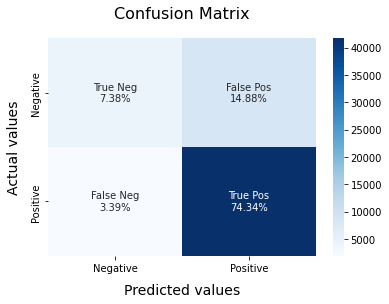

In [ ]:
#model evaluation
%%time
model_Evaluate(lr_bow)

### Word2Vec

* word2vec does is that it trains a shallow neural network model in an unsupervised manner for converting words to vectors. 
* Word2vec is strong at capturing the meanings of the words, so it's also good at detecting words that have similar meanings.

#### Featuring engineering

* workers=4: Set the number of threads to run in parallel to 4 (which makes sense if your computer has available computing units).
* min_count=1: Set the minimum word count threshold to 1.
* window=6: Set the number of words around the target word to consider to 6.
* sg=0: Use CBOW because your corpus is small.
* sample=1e-3: Penalize frequent words.
* size=100: Set the word vector length to 100.
* hs=1: Use hierarchical softmax.

In [ ]:
%%time
# Train word2vec on the sentences
model = gensim.models.Word2Vec(
    text["Text"],
    workers=4,
    min_count=1,
    window=6,
    sg=0,
    sample=1e-3,
    size=100,
    hs=1
)

CPU times: user 8min 52s, sys: 6.21 s, total: 8min 58s
Wall time: 4min 56s


In [ ]:
%%time
word2vec_arr = np.zeros((data.shape[0],100))

for i, sentence in enumerate(text["Text"]):
    word2vec_arr[i,:] = np.mean([model[lemma] for lemma in sentence], axis=0)

word2vec_arr = pd.DataFrame(word2vec_arr)
data_w2v = pd.concat([text[["Score", "Text"]],word2vec_arr], axis=1)
data_w2v.dropna(inplace=True)

data_w2v.head()

CPU times: user 8min 42s, sys: 1.32 s, total: 8min 44s
Wall time: 8min 48s


,Score,Text,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,Positive,bought several vitality canned dog food produc...,0.233423,0.291423,0.331718,0.245881,0.031560,-0.036769,-0.052710,-0.352594,...,-0.011885,0.043711,0.016787,0.025396,-0.154160,-0.031526,-0.305048,-0.060213,0.268474,0.030230
1,Negative,product arrived labeled jumbo salted peanuts p...,0.253770,0.268776,0.316736,0.343842,0.033088,-0.044518,-0.007326,-0.251809,...,0.021756,0.025843,0.061065,0.020555,-0.153487,-0.036505,-0.322328,-0.008947,0.293293,0.062253
2,Positive,confection around centuries light pillowy citr...,0.282037,0.303861,0.342980,0.260017,0.067528,-0.087788,-0.090432,-0.336853,...,-0.066630,0.028699,0.021221,0.013094,-0.126291,0.008441,-0.308553,-0.049238,0.259518,0.022802
3,Negative,looking secret ingredient robitussin believe f...,0.251612,0.331974,0.339002,0.271069,0.101305,-0.068334,-0.032096,-0.334415,...,-0.022127,0.057706,0.059107,0.058558,-0.148170,-0.029856,-0.297063,-0.033925,0.230564,0.036995
4,Positive,great taffy great price wide assortment yummy ...,0.332554,0.348599,0.323440,0.299942,0.049120,-0.085749,-0.120599,-0.282360,...,-0.070828,0.017792,-0.021392,-0.038334,-0.176570,-0.039964,-0.339727,-0.099442,0.261465,-0.015132


In [ ]:
Y = data_w2v['Score']
X = np.array(data_w2v.drop(['Text','Score'], 1))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [ ]:
def model_Evaluate(model):    
  # Predict values for Test dataset
  y_pred = model.predict(X_test)

  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)

  categories  = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
              xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':16}, pad = 20)

#### Model

In [ ]:
%%time
#testing how fit of the dataset
BNBmodel_w2v = BernoulliNB(alpha = 2)
BNBmodel_w2v.fit(X_train, y_train)
print("----------------------Naive Bayes Scores----------------------")
print('Training set score:', BNBmodel_w2v.score(X_train, y_train))
print('Tesing set score:', BNBmodel_w2v.score(X_test, y_test))

----------------------Naive Bayes Scores----------------------
Training set score: 0.7809531168581578
Tesing set score: 0.7773577503967476
CPU times: user 3.96 s, sys: 409 ms, total: 4.37 s
Wall time: 3.88 s


In [ ]:
%%time
#making prediction
predictions_BNBmodel_w2v = BNBmodel_w2v.predict_proba(X_train)

#log loss
logloss_w2v_bnb = log_loss(y_train, predictions_BNBmodel_w2v)

print ("logloss:  {:.3f}".format(logloss_w2v_bnb))

#accuracy score
BNBmodel_w2v_score = BNBmodel_w2v.score(X_test, y_test)

logloss:  0.533
CPU times: user 2.41 s, sys: 220 ms, total: 2.63 s
Wall time: 2.31 s


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     12486
    Positive       0.78      1.00      0.87     43595

    accuracy                           0.78     56081
   macro avg       0.39      0.50      0.44     56081
weighted avg       0.60      0.78      0.68     56081

CPU times: user 1.84 s, sys: 108 ms, total: 1.95 s
Wall time: 1.82 s


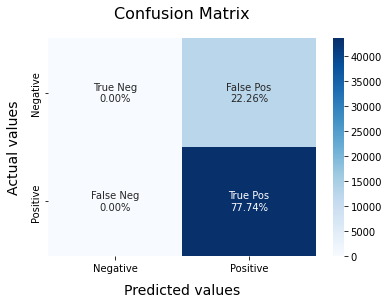

In [ ]:
#model evaluation
%%time
model_Evaluate(BNBmodel_w2v)

In [ ]:
%%time
#testing how fit of the dataset
lr_w2v = LogisticRegression()
lr_w2v.fit(X_train, y_train)
print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr_w2v.score(X_train, y_train))
print('Tesing set score:', lr_w2v.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.7809531168581578
Tesing set score: 0.7773577503967476
CPU times: user 26.3 s, sys: 5.47 s, total: 31.8 s
Wall time: 17.2 s


In [ ]:
%%time
#making prediction
predictions_lr_w2v = lr_w2v.predict_proba(X_train)

#log loss
logloss_w2v_lr = log_loss(y_train, predictions_lr_w2v)

print ("logloss:  {:.3f}".format(logloss_w2v_lr))

#accuracy score
lr_w2v_score = lr_w2v.score(X_test, y_test)

logloss:  0.526
CPU times: user 1.74 s, sys: 209 ms, total: 1.95 s
Wall time: 1.68 s


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     12486
    Positive       0.78      1.00      0.87     43595

    accuracy                           0.78     56081
   macro avg       0.39      0.50      0.44     56081
weighted avg       0.60      0.78      0.68     56081

CPU times: user 2.12 s, sys: 115 ms, total: 2.24 s
Wall time: 2.11 s


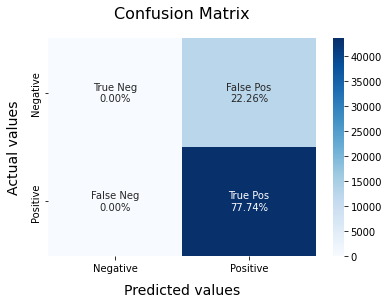

In [ ]:
#model evaluation
%%time
model_Evaluate(lr_w2v)

### TF-IDF
* Term Frequency(TF) and Inverse Document Frequency(IDF). 
  * TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
  *  IDF actually tells us how important the word is to the document. This is because when we calculate TF, we give equal importance to every single word. If the word appears in the dataset more frequently, then its term frequency (TF) value is high while not being that important to the document.

#### Feature Engineering

In [ ]:
%%time
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=560804)
vectoriser.fit(text['Text'])
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  560804
CPU times: user 57.6 s, sys: 1.17 s, total: 58.8 s
Wall time: 58.6 s


In [ ]:
#transform
x = vectoriser.transform(text['Text'])
y = text['Score']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.1, random_state = 0)

In [ ]:
def model_Evaluate(model):    
  # Predict values for Test dataset
  y_pred = model.predict(X_test)

  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)

  categories  = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
              xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':16}, pad = 20)

#### Model

In [ ]:
%%time
#testing how fit of the dataset
BNBmodel_tf = BernoulliNB(alpha = 2)
BNBmodel_tf.fit(X_train, y_train)
print("----------------------Naive Bayes Regression Scores----------------------")
print('Training set score:', BNBmodel_tf.score(X_train, y_train))
print('Tesing set score:', BNBmodel_tf.score(X_test, y_test))

----------------------Naive Bayes Regression Scores----------------------
Training set score: 0.8867735371679119
Tesing set score: 0.8690108949555108
CPU times: user 3.75 s, sys: 18.9 ms, total: 3.77 s
Wall time: 3.75 s


In [ ]:
%%time
#making prediction
predictions_BNBmodel_tf = BNBmodel_tf.predict_proba(X_train)

#log loss
logloss_tf_bnb = log_loss(y_train, predictions_BNBmodel_tf)

print ("logloss:  {:.3f}".format(logloss_tf_bnb))

#accuracy score
BNBmodel_tf_score = BNBmodel_tf.score(X_train, y_train)

logloss:  1.002
CPU times: user 3.63 s, sys: 18.9 ms, total: 3.65 s
Wall time: 3.63 s


              precision    recall  f1-score   support

    Negative       0.74      0.63      0.68     12486
    Positive       0.90      0.94      0.92     43595

    accuracy                           0.87     56081
   macro avg       0.82      0.79      0.80     56081
weighted avg       0.86      0.87      0.87     56081

CPU times: user 1.87 s, sys: 15 ms, total: 1.88 s
Wall time: 1.87 s


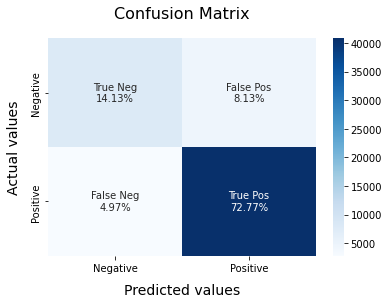

In [ ]:
%%time
model_Evaluate(BNBmodel_tf)

In [ ]:
%%time
#testing how fit of the dataset
lr_tf = LogisticRegression()
lr_tf.fit(X_train, y_train)
print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr_tf.score(X_train, y_train))
print('Tesing set score:', lr_tf.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.9407060902712974
Tesing set score: 0.9232538649453469
CPU times: user 50.6 s, sys: 26.2 s, total: 1min 16s
Wall time: 47.7 s


In [ ]:
%%time
#making prediction
predictions_lr_tf = lr_tf.predict_proba(X_train)

#log loss
logloss_tf_lr = log_loss(y_train, predictions_lr_tf)

print ("logloss:  {:.3f}".format(logloss_tf_lr))

#accuracy score
lr_tf_score = lr_tf.score(X_train, y_train)

logloss:  0.177
CPU times: user 2.86 s, sys: 20.8 ms, total: 2.88 s
Wall time: 2.87 s


              precision    recall  f1-score   support

    Negative       0.89      0.75      0.81     12486
    Positive       0.93      0.97      0.95     43595

    accuracy                           0.92     56081
   macro avg       0.91      0.86      0.88     56081
weighted avg       0.92      0.92      0.92     56081

CPU times: user 2.09 s, sys: 8.87 ms, total: 2.1 s
Wall time: 2.1 s


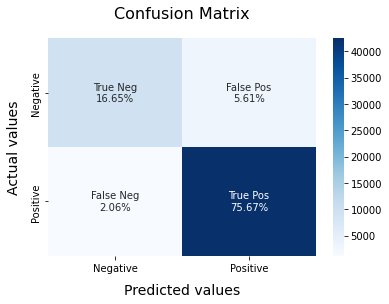

In [ ]:
%%time
model_Evaluate(lr_tf)

### Evaluation

In [ ]:
#create dataframe to store the log loss
eva_log_loss = pd.DataFrame([['BernoulliNB',logloss_bow_bnb,logloss_w2v_bnb, logloss_tf_bnb],
                          ['Logistic Regression', logloss_bow_lr, logloss_w2v_lr, logloss_tf_lr]],
                          columns = ["Classifier_Model",'Bag of Word', 'Word to Vector', 'TF-DIF']
                          )
eva_log_loss

,Classifier_Model,Bag of Word,Word to Vector,TF-DIF
0,BernoulliNB,0.446901,0.533023,1.001646
1,Logistic Regression,0.402484,0.525640,0.177399


In [ ]:
#create ataframe to store the accuracy score
eva_accuracy = pd.DataFrame([['BernoulliNB',BNBmodel_bow_score, BNBmodel_w2v_score, BNBmodel_tf_score],
                          ['Logistic Regression', lr_bow_score, lr_w2v_score, lr_tf_score]],
                          columns = ["Classifier_Model",'Bag of Word', 'Word to Vector', 'TF-DIF']
                          )
eva_accuracy

,Classifier_Model,Bag of Word,Word to Vector,TF-DIF
0,BernoulliNB,0.793620,0.777358,0.886774
1,Logistic Regression,0.817264,0.777358,0.940706


* TF-IDF is the best model that has the highest accuracy score for both NernoulliNB and Logistic regression
* Logistic Regresison is the best model that fit in this dataset because it bring the highest accuracy score with the lowest log loss

### Tuning Parameter

In [ ]:
# We will use logistic regression here..
lr_model = LogisticRegression()

# Create the pipeline 
clf = pipeline.Pipeline([('lr', lr_model)])

In [ ]:
param_grid = {'lr__C': [0.01, 0.1, 1.0, 10.0, 100.0], 
              'lr__penalty': ['l1', 'l2','elasticnet', 'none'],
              'lr__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

In [ ]:
# Initialize Grid Search Model
model_lr = GridSearchCV(estimator=clf, param_grid=param_grid,
                                 verbose=10)


In [ ]:
%%time 
# Fit Grid Search Model
# I use the full data
model_lr.fit(X_test, y_test)  

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5; 1/80] START lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg...........
[CV 1/5; 1/80] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5; 1/80] START lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg...........
[CV 2/5; 1/80] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5; 1/80] START lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg...........
[CV 3/5; 1/80] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5; 1/80] START lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg...........
[CV 4/5; 1/80] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5; 1/80] START lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg...........
[CV 5/5; 1/80] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5; 2/80] START lr__C=0.01, lr__p

In [ ]:
print("Best score: %0.3f" % model_lr.best_score_)
print("Best parameters set:")
best_parameters = model_lr.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
%%time
#testing how fit of the dataset
print("----------------------Logistic Regression Tunning Scores----------------------")
print('Training set score:', model_lr.score(X_train, y_train))
print('Tesing set score:', model_lr.score(X_test, y_test))

In [ ]:
%%time
#data is overfiting
#apply KFolds cross validation method
model_lr_kfold = LogisticRegression(C=1, penalty='none', solver='saga')
model_lr_kfold.fit(X_test, y_test)

In [ ]:
%%time
#K-fold = 2, finding the best fit accuracy score
#higher return accuracy score are better than lower return accuracy score.
cv_r2_scores_lr = cross_val_score(model_lr_kfold, X_train, y_train, cv=5,scoring='accuracy') 
print(cv_r2_scores_lr)
print("Mean 5-Fold R Squared: {}".format(np.mean(cv_r2_scores_lr)))

## Top worlds in text
* TF-DIF is the best statistical measure that evaluates how relevant a word is to a document in this dataset.
* I will cluster top words with K-mean and visuallized it

###K-mean

In [ ]:
#Apply KMean with the evaluation based on Silhouette Score
%%time
sil_k = np.arange(17,dtype="double")
for k in np.arange(17):
  minikm = MiniBatchKMeans(n_clusters=k+2, random_state=0)
  minikm.fit(X_test)
  sil_k[k] = silhouette_score(X_test,minikm.labels_,metric='euclidean')
   
print(sil_k)

plt.title("Mini Batch KMeans Silhouette")
plt.xlabel("Number of Cluster")
plt.plot(np.arange(2,19,1),sil_k)

NameError: ignored

Compare to all number of clusters, cluster of 3 is the best one with the highest Silhoutte score

In [ ]:
%%time
model = KMeans(n_clusters=3,  random_state=0)
res = model.fit(X_test)

In [ ]:
%%time
print ('Most Common Terms per Cluster:')

order_centroids = model.cluster_centers_.argsort()[:,::-1] #sort cluster centers by proximity to centroid
terms = vectoriser.get_feature_names()

for i in range(3):
    print("\n")
    print('Cluster %d:' % i)
    for j in order_centroids[i, :17]: #replace 17 with n words per cluster
        print ('%s' % terms[j]),
    print

In [ ]:
vocab = np.array(terms)
cluster_centers = np.array(res.cluster_centers_)
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]
words=set()
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))
words=list(words)
words

###t-SNE visuallize

In [ ]:
%%time
#apply svd reduce component to visuallize
#Lets's try to extract components via TruncatedSVD
#Maximum component are 20-70
svd = TruncatedSVD(n_components=50) #I chose 50

#fit svd into K-Mean test
svd.fit(X_test)

## Transform x
k_mean_text = svd.transform(X_test)

In [ ]:
%%time
tsne = TSNE(n_components=3, perplexity=50, n_iter =1000, random_state=0)
words_top_ted_tsne = tsne.fit_transform(k_mean_text)

In [ ]:
#tranfer sentiment to interger
lbl_enc = LabelEncoder()
y_test = lbl_enc.fit_transform(y_test)

In [ ]:
#marker_color should be a list of numbers, not strings
marker_color= np.array(y_test).astype(int) #

#3d plot function
def plot_2d(component1,component2):
  colours = ["c","w"]
  fig = go.Figure(data=[go.Scatter(
        x=component1,
        y=component2,
        mode='markers',
        marker=dict(
            size=10,
            color=marker_color,                
            colorscale='Rainbow',   # choose a colorscale
            opacity=1,
            line_width=1))])
  
# tight layout
  fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1800,height=1000)
  fig.layout.template = 'plotly_dark'
  
  fig.show()

In [ ]:
plot_2d(words_top_ted_tsne[:,0], words_top_ted_tsne[:,1])

In [ ]:
#marker_color should be a list of numbers, not strings
marker_color= np.array(y_test).astype(int) #

#3d plot function
def plot_3d(component1,component2,component3):
  colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
  fig = go.Figure(data=[go.Scatter3d(
        x=component1,
        y=component2,
        z=component3,
        mode='markers',
        marker=dict(
            size=10,
            color=marker_color,                
            colorscale='Rainbow',   # choose a colorscale
            opacity=1,
            line_width=1))])
  
# tight layout
  fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1800,height=1000)
  fig.layout.template = 'plotly_dark'
  
  fig.show()


In [ ]:
plot_3d(words_top_ted_tsne[:,0], words_top_ted_tsne[:,1], words_top_ted_tsne[:,2])

## Deep learning

### Feature Engineering

* Tokenizer allows to vectorize a text corpus, by turning each text into either a sequence of integers
* the maximum number of words to keep is 600, based on word frequency. Only the most common words will be kept.
* Maximum length of all sequences is 130

In [ ]:
top_words = 6000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(text['Text'])
list_tokenized_train = tokenizer.texts_to_sequences(text['Text'])

max_review_length = 130
x = pad_sequences(list_tokenized_train, maxlen=max_review_length)

#tranfer sentiment to interger
y = text['Score']
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y)

print(x.shape)
print(y.shape)

In [ ]:
x_train,x_test, y_train, y_test=train_test_split(x,y,test_size=0.1,random_state=0)

### ANN

* Artificial neural networks with one input, one hidden layer and one output
* Since the maximum length is 130, the first layer has 130 neurons with the activation is relu
* There are 5 hidden layers, each layer cut half of the neuron from the previous one with the activation is relu
* Because we are trying to predict Positive and Negative review, it is a binary with the activation is sigmoi

In [ ]:
model_1 = Sequential()

model_1.add(Dense(130, activation='relu'))


model_1.add(Dense(65, activation='relu'))


model_1.add(Dense(30, activation='relu'))


model_1.add(Dense(15, activation='relu'))


model_1.add(Dense(7, activation='relu'))


model_1.add(Dense(3, activation='relu'))


model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
model_1.fit(x=x_train,y=y_train,epochs=10,validation_data=(x_test,y_test), callbacks=[early_stop])

In [ ]:
model_1_sum = pd.DataFrame(model_1.history.history)
model_1_sum

In [ ]:
plt.figure(figsize=(10,4))

#plot log_loss
plt.subplot(1,2,1)
list_epoch=np.arange(0,3)
plt.plot(list_epoch,model_1_sum['loss'])
plt.plot(list_epoch,model_1_sum['val_loss'])
plt.ylabel('Loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.grid(linewidth=0.5,alpha=0.75)
plt.legend(['train_loss','val_loss'],fontsize=9)
plt.title('Loss (train/validation) vs. number of epochs',fontsize=12)

#plot accuracy
plt.subplot(1,2,2)
plt.plot(list_epoch,model_1_sum['accuracy'])
plt.plot(list_epoch,model_1_sum['val_accuracy'])
plt.ylabel('Accuracy',fontsize=12)
plt.legend(['train_acc','val_acc'],fontsize=9)
plt.grid(linewidth=0.5,alpha=0.75)
plt.title('Accuracy (train/validation) vs. number of epochs',fontsize=12)
plt.xlabel('epoch',fontsize=12)

plt.tight_layout()

In [ ]:
def plot_cm(name):    
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_final, y_pred)

  categories  = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
              xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':16}, pad = 20)

In [ ]:
%%time
list_tokenized_test = tokenizer.texts_to_sequences(text['Text'])
x_final = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_final = y
prediction = model_1.predict(x_final)
y_pred = (prediction > 0.5)

In [ ]:
print("Accuracy of the model : ", accuracy_score(y_pred, y_final))
print('F1-score: ', f1_score(y_pred, y_final))
cm = confusion_matrix(y_final,y_pred)

In [ ]:
plot_cm(cm)

###LSTM

* An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. Embeddings make it easier to do machine learning on large inputs like sparse vectors representing words. Ideally, an embedding captures some of the semantics of the input by placing semantically similar inputs close together in the embedding space. An embedding can be learned and reused across models.
* The Keras Embedding layer requires all individual documents to be of same length.
* Long Short-Term Memory (LSTM) has a similar control flow as a recurrent neural network. It processes data passing on information as it propagates forward
* Firstly, I pass the previous hidden state and current input into a function. That decides which values will be updated by transforming the values to be between 0 and 1. 0 means Negative, and 1 means Positive
* Secondly, the Cell State gets pointwise multiplied by the forget vector. This has a possibility of dropping values in the cell state if it gets multiplied by values near 0. Then I take the output from the input gate and do a pointwise addition which updates the cell state to new values that the neural network finds relevant
* Lastly, The output gate decides what the next hidden state should be. Remember that the hidden state contains information on previous inputs. The hidden state is also used for predictions. we pass the previous hidden state and the current input into a sigmoid function

In [ ]:
embedding_vecor_length = 32
model_2 = Sequential()
model_2.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model_2.add(LSTM(100))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

In [ ]:
model_2.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
model_2.fit(x=x_train,y=y_train,epochs=10,validation_data=(x_test,y_test), callbacks=[early_stop])

In [ ]:
model_2_sum = pd.DataFrame(model_2.history.history)
model_2_sum

In [ ]:
plt.figure(figsize=(10,4))

#plot log_loss
plt.subplot(1,2,1)
list_epoch=np.arange(0,6)
plt.plot(list_epoch,model_2_sum['loss'])
plt.plot(list_epoch,model_2_sum['val_loss'])
plt.ylabel('Loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.grid(linewidth=0.5,alpha=0.75)
plt.legend(['train_loss','val_loss'],fontsize=9)
plt.title('Loss (train/validation) vs. number of epochs',fontsize=14)

#plot accuracy
plt.subplot(1,2,2)
plt.plot(list_epoch,model_2_sum['accuracy'])
plt.plot(list_epoch,model_2_sum['val_accuracy'])
plt.ylabel('Accuracy',fontsize=12)
plt.legend(['train_acc','val_acc'],fontsize=9)
plt.grid(linewidth=0.5,alpha=0.75)
plt.title('Accuracy (train/validation) vs. number of epochs',fontsize=14)
plt.xlabel('epoch',fontsize=12)

plt.tight_layout()

In [ ]:
%%time
list_tokenized_test = tokenizer.texts_to_sequences(text['Text'])
x_final = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_final = y
prediction = model_2.predict(x_final)
y_pred = (prediction > 0.5)

In [ ]:
print("Accuracy of the model : ", accuracy_score(y_pred, y_final))
print('F1-score: ', f1_score(y_pred, y_final))
cm = confusion_matrix(y_final,y_pred)

In [ ]:
plot_cm(cm)